In [1]:
import numpy as np
import os
import torch 
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader


In [2]:
from conv import ConvNet
from data import FaceLoader_IMM, FaceLoader_IMM_Transform
from transformations import Transformation, Rescale, Rotate, Shift, FlipX

%load_ext autoreload
%autoreload 2

# Code for transformations of images, preserving landmark positions.

<h3>Rescale and Random Crop Data Taken from here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html  </h3>

In [3]:
##Useful pytorch functions from my cs285 class!

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

def sqz_g(im_g):
    return im[None][None]
    
    
device = None
def init_gpu(use_gpu=True, gpu_id=0):
    global device
    if torch.cuda.is_available() and use_gpu:
        device = torch.device("cuda:" + str(gpu_id))
        print("Using GPU id {}".format(gpu_id))
    else:
        device = torch.device("cpu")
        print("GPU not detected. Defaulting to CPU.")
        


In [4]:
#Plot image and landmarks
def show_img_land(smp, p=None, sz=6, title=None):
    im = smp['im']
    lm = smp['lm']
    
    lm = rel_to_abs(im, lm)
    
    if not p:
        p = plt
    p.axis("off")
    p.imshow(im, cmap='gray'), p.scatter(lm[:, 0], lm[:, 1], s = sz)
    if title:
        p.set_title(title)
        
    
#Relative to absolute coordinates
def rel_to_abs(im, landmarks):
    """
    x, y tuple of relative and im.
    """
    result = np.zeros(landmarks.shape)
    for i in range(len(result)):
        result[i, :] = im.shape[1] * landmarks[i, 0], im.shape[0] * landmarks[i, 1]
    return result

def rel_to_abs_1d(im, lm):
    return np.array([lm[0] * im.shape[1], lm[1] * im.shape[0]])


## Q1:

## Dataloader:

In [5]:
dataset = FaceLoader_IMM(trans=Rescale((80, 60)))

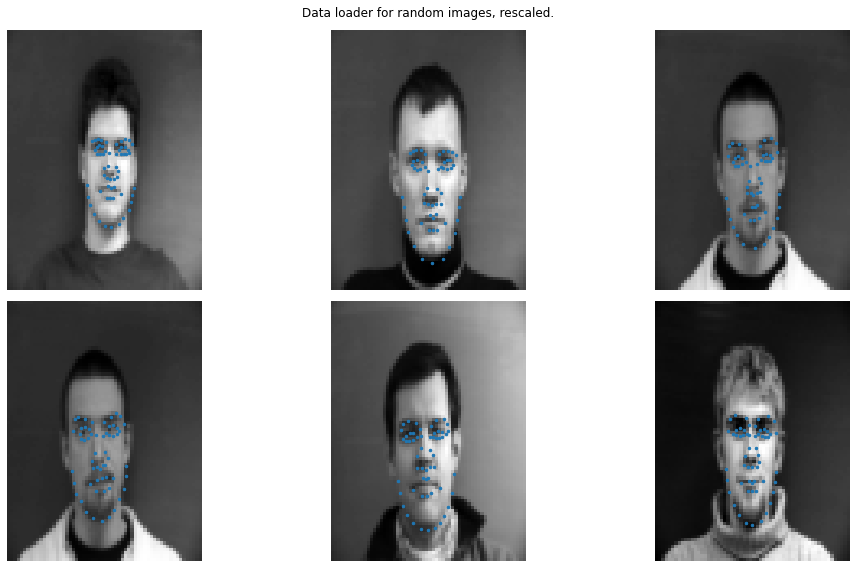

In [6]:
f, axs = plt.subplots(2, 3, figsize=(15, 8))

plt.suptitle("Data loader for random images, rescaled.")

for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(dataset))
        
        res = dataset[idx]

        show_img_land(res, axs[i, j])
f.tight_layout()

In [7]:
dataset = FaceLoader_IMM(trans=Rescale((80, 60)), landmarks=[-6])

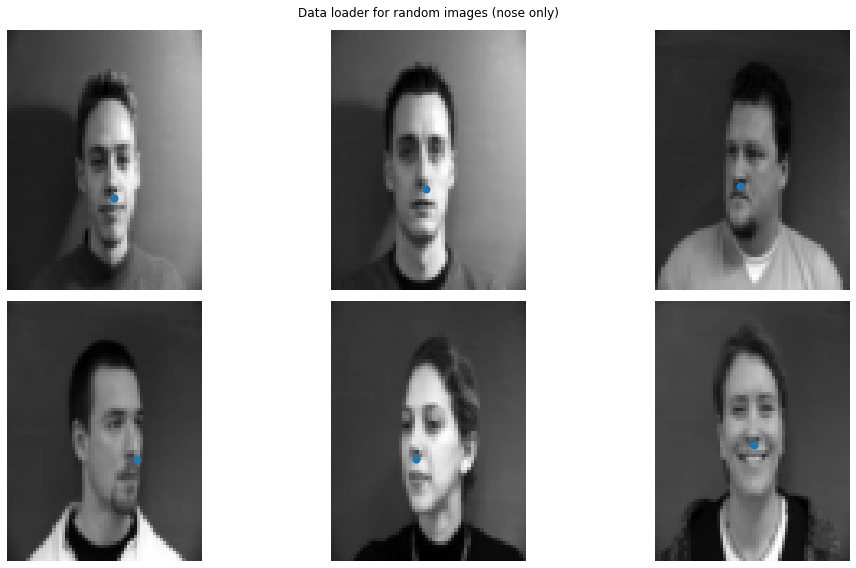

In [8]:
f, axs = plt.subplots(2, 3, figsize=(15, 8))

plt.suptitle("Data loader for random images (nose only)")

for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(dataset))
        
        res = dataset[idx]

        show_img_land(res, axs[i, j], sz=50)
f.tight_layout()

## Training our ConvNet

In [9]:
#3 convolutional layers all 12 channels
chan_list = [1, 6, 6, 16]
kern_sizes = [5, 5, 5]
pool_sizes = [2, 2, 2]

In [12]:
dataset = FaceLoader_IMM(trans=Rescale((90, 60)), landmarks=[-6],)

eval_dataset = FaceLoader_IMM(trans=Rescale((90, 60)), evl = True, landmarks=[-5])

im = dataset[0]['im']
net = ConvNet(chan_list, kern_sizes, pool_sizes, [120, 84, 2], im.shape, s=1, learn=1e-4)


dl = DataLoader(dataset, batch_size=32, shuffle=True)
dl_evl = DataLoader(eval_dataset, batch_size = 16, shuffle=False)

losses = net.run_training_loop(dl, dl_evl, 20)



GPU not detected. Defaulting to CPU.


## Examine the results

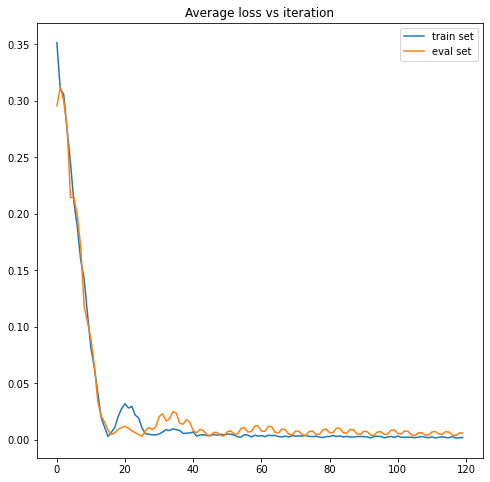

In [13]:
tl, el = losses

plt.figure(figsize=(8, 8))
plt.plot(tl, label='train set')
plt.plot(el, label='eval set')
plt.title("Average loss vs iteration")
plt.legend()
plt.show()

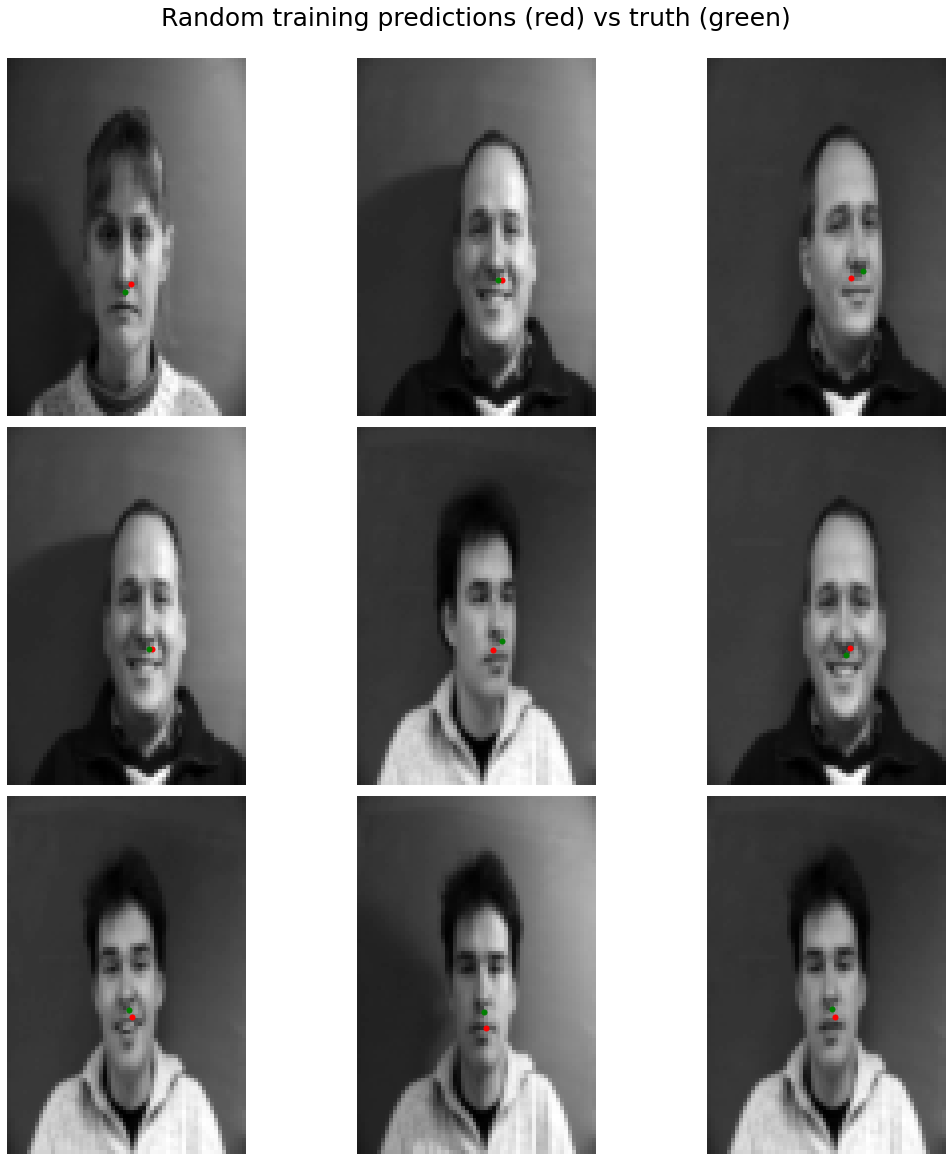

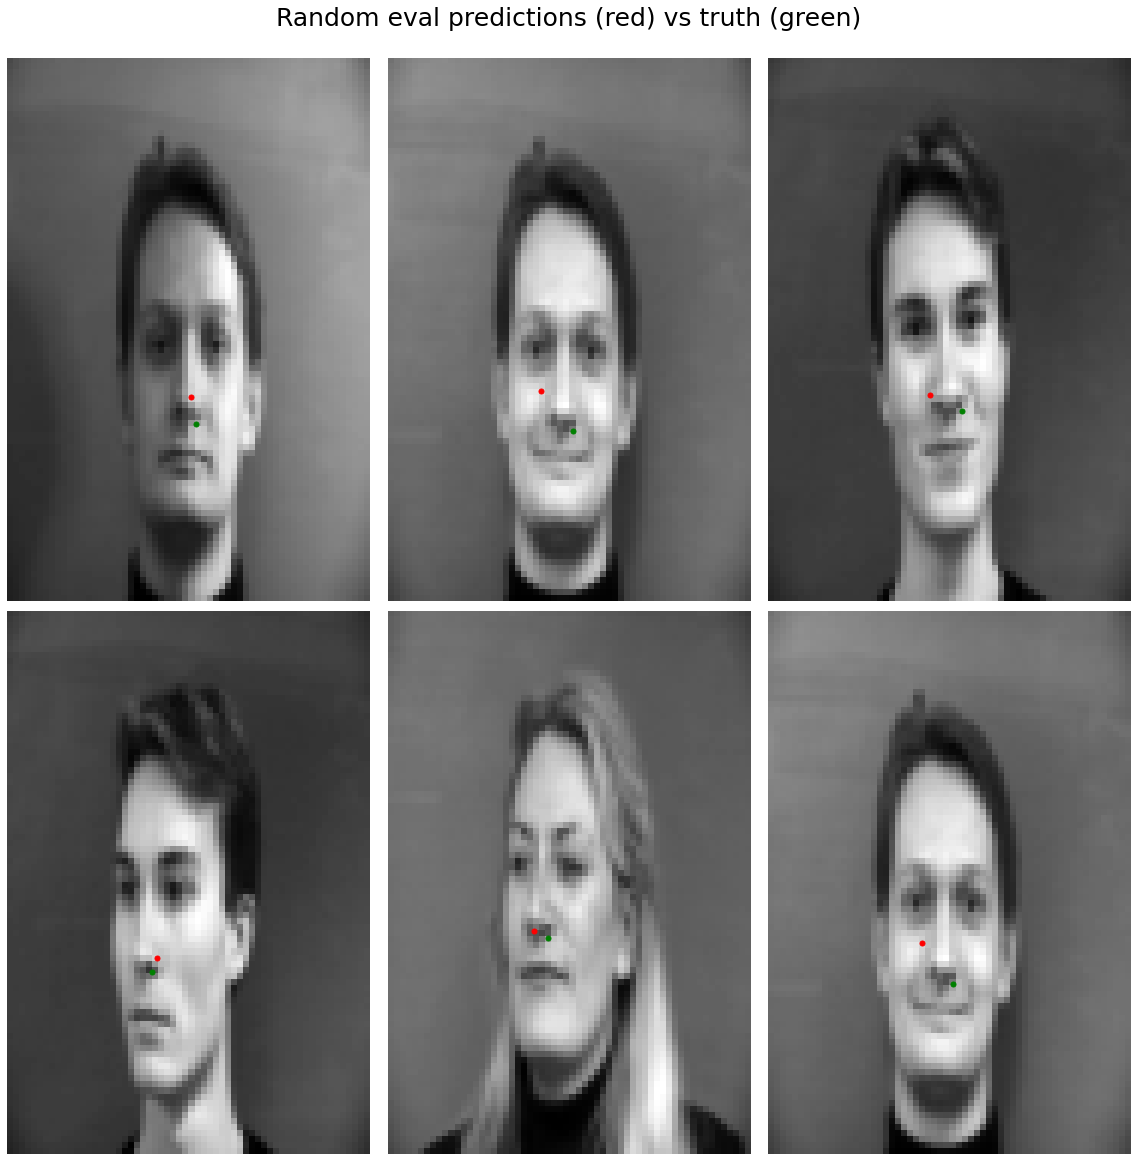

In [15]:
def plot_result_nose(dataset, net, i, p=None, sz=25):
    """
    Plot the result of dataset idx i produced by net.
    """
    sample = dataset[i]
    im = sample['im']
    unsqz_im, tgt = from_numpy(im)[None][None], sample['lm'][0]

    pred = to_numpy(net.forward(unsqz_im))[0]

    ac_pred, ac_tgt = rel_to_abs_1d(im, pred), rel_to_abs_1d(im, tgt)
    
    if p:
        p.imshow(im, cmap='gray'), p.axis('off')
        p.scatter(ac_pred[0], ac_pred[1], c = 'r', s=sz)
        p.scatter(ac_tgt[0], ac_tgt[1], c= 'g', s=sz)
    return np.linalg.norm(ac_pred - ac_tgt)


f, axs = plt.subplots(3, 3, figsize=(16, 16))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(eval_dataset))
        plot_result_nose(dataset, net, idx, p=axs[i][j])

plt.suptitle("Random training predictions (red) vs truth (green)", y=1.005, fontsize=25)
f.tight_layout() 

f, axs = plt.subplots(2, 3, figsize=(16, 16))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(eval_dataset))
        plot_result_nose(eval_dataset, net, idx, p=axs[i][j])

plt.suptitle("Random eval predictions (red) vs truth (green)", y=1.005, fontsize=25)
f.tight_layout() 


This is the results of our neural net architecture (a variant of LeNet) on a subset of random faces of both the training and test datasets. <br><br> <b> **Red is prediction of net and green is true label </b> <br> 

We see on images from the eval dataset where the heads are angled performed poorly. We likeley need data augmentation to help the net generalize better.

In [16]:
lst_eval = []
lst_train = []

#Get the best and worst predictions
for i in range(len(eval_dataset)):
    loss = plot_result_nose(eval_dataset, net, i)
    lst_eval.append((loss, i))

lst_eval = sorted(lst_eval, key=lambda x: x[0])


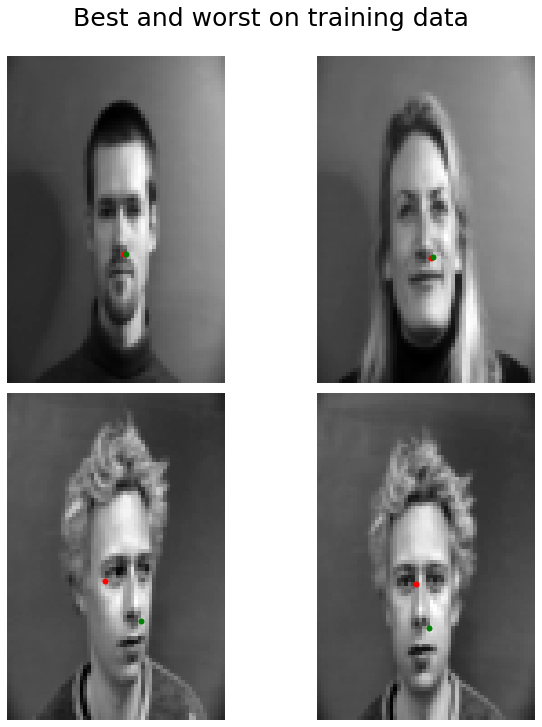

In [17]:
lst = [0, 1, -1, -2]
cntr = 0
f, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        plot_result_nose(eval_dataset, net, lst_eval[lst[cntr]][1], p=axs[i][j])
        cntr += 1

plt.suptitle("Best and worst on training data", y=1.005, fontsize=25)
f.tight_layout() 


These two that turned out poorly look quite different than the "average man" we calculated earlier and are very much so out of distribution. This is evaluation data so our classifier never saw these two before so the baldness and the wild messy hair probably threw our classifier for a loop. <br> <br> Notice how the two with great performance look quite "normal" in the sense they are closer to the average man.

## Part 2: Full Facial Keypoints Detection

### Transformation testing

In [5]:
dataset = FaceLoader_IMM()
s = Shift(20, 20)  
r = Rotate(15)
fl = FlipX()

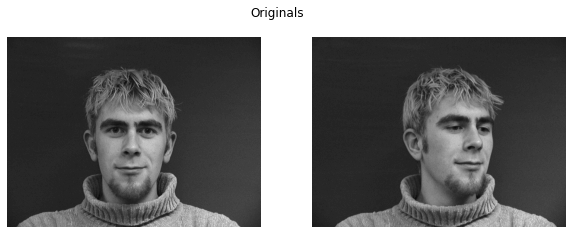

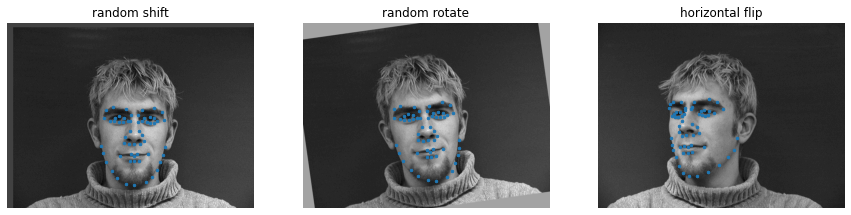

In [6]:

s1, s2, s3 = dataset[0], dataset[0], dataset[3]

s(s1), r(s2), fl(s3)


f, ax = plt.subplots(1, 2, figsize=(10, 5))

plt.suptitle("Originals", y=.85)
ax[0].imshow(dataset[0]['im'], cmap='gray'), ax[0].axis('off')
ax[1].imshow(dataset[3]['im'], cmap='gray'), ax[1].axis('off')
plt.show()

#Plot augmented data
f, ax = plt.subplots(1, 3, figsize=(15, 10))

show_img_land(s1, p=ax[0], title='random shift')
show_img_land(s2, p=ax[1], title='random rotate')
show_img_land(s3, p=ax[2], title='horizontal flip')


### Dataloader testing:

In [7]:
t_list = [Transformation(), Shift(20, 20), Rotate(15), FlipX()]
r = Rescale((160, 120))

#Don't augment evaldata
ds = FaceLoader_IMM_Transform(t_list, trans = r)
ds_e = FaceLoader_IMM(trans=Rescale((160, 120)), evl = True)



dl = DataLoader(ds, batch_size=1, shuffle=True)


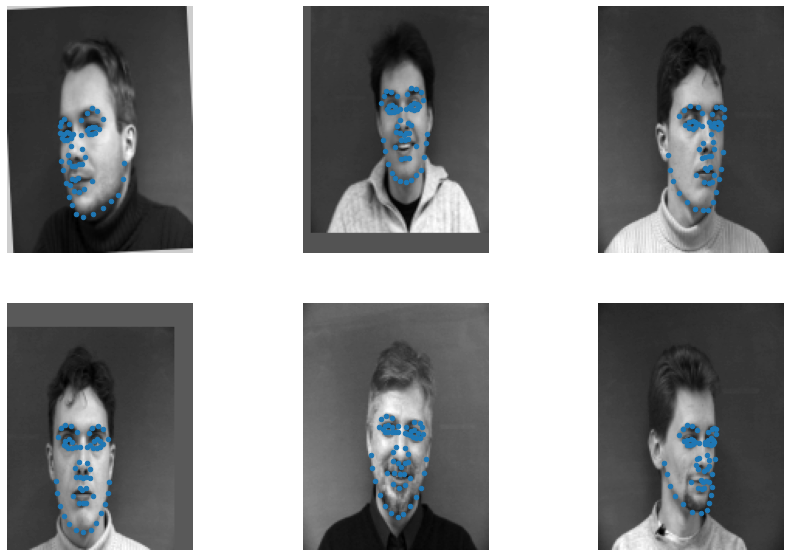

In [10]:
itr = iter(dl)

f, ax = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    for j in range(3):
        b = next(itr)
    
        im, lm = b['im'][0], b['lm'][0]

        pts = to_numpy(lm)

        pts[:, 0] *= im.shape[1]
        pts[:, 1] *= im.shape[0]

        ax[i][j].imshow(im, cmap='gray'), ax[i][j].axis("off")
        ax[i][j].scatter(pts[:, 0], pts[:, 1], s=20)
        

    

## ConvNet 2:

In [11]:
r = Rescale((160, 120))


#Don't augment evaldata
ds = FaceLoader_IMM_Transform(t_list, trans = r, numworkers=2)
ds_e = FaceLoader_IMM(trans=r, evl = True)

In [12]:
#3 convolutional layers all 12 channels
chan_list = [1, 32, 16, 12, 12]
kern_sizes = [3, 3, 3, 3]
pool_sizes = [2, 2, 2, 2]

In [13]:
im = ds[0]['im']

net = ConvNet(chan_list, kern_sizes, pool_sizes, [1000, 500, 116], im.shape, dropout =0, s=1, learn=1e-3)


dl = DataLoader(ds, batch_size=32, shuffle=True)
dl_evl = DataLoader(ds_e, batch_size = 16, shuffle=True)


GPU not detected. Defaulting to CPU.


In [14]:
losses = net.run_training_loop(dl, dl_evl, 4, multi_pt=True)

### Random samples of our algo

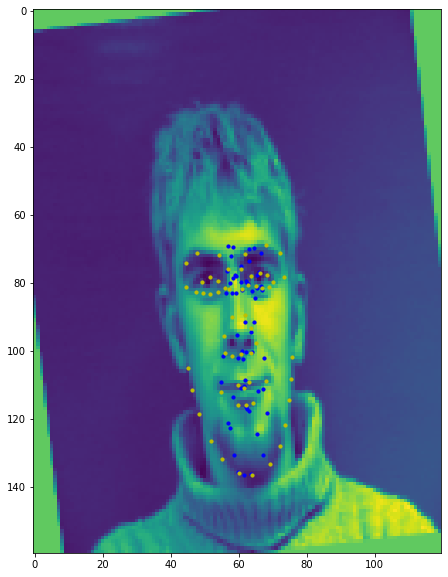

In [23]:
def rel_to_abs(im, pt):
    result = np.zeros(pt.shape)
    result[:, 0] = pt[:, 0] * im.shape[1]
    result[:, 1] = pt[:, 1] * im.shape[0]
    return result

def get_loss_plot_result(dataset, net, i, p=None, sz=25):
    """
    Plot the result of dataset idx i produced by net.
    """
    sample = dataset[i]
    im, tgt = sample['im'], sample['lm']
    
    unsqz_im, tgt = from_numpy(im)[None][None], from_numpy(sample['lm'])

    pred = to_numpy(net.forward(unsqz_im).detach().reshape(58, 2))
    pred = rel_to_abs(im, pred)
    tgt = rel_to_abs(im, tgt)
    
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.scatter(pred[:,0], pred[:, 1], s=10, c='b')
    plt.scatter(tgt[:,0], tgt[:,1], c='y', s =10)
    
    
#     if p:
#         p.imshow(im, cmap='gray'), p.axis('off')
#         p.scatter(ac_pred[:, 0], ac_pred[:, 1], c = 'r', s=sz)
#         p.scatter(ac_tgt[:, 0], ac_tgt[:, 1], c= 'g', s=sz)
#     return np.linalg.norm(ac_pred - ac_tgt)
                       
                       
get_loss_plot_result(ds, net, 2)

### Plotting results

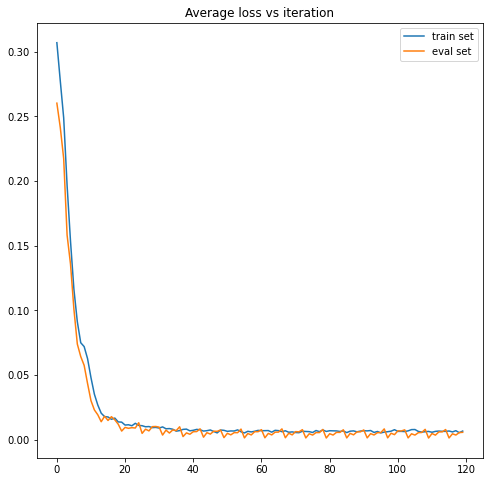

In [19]:
tl, el = losses

plt.figure(figsize=(8, 8))
plt.plot(tl, label='train set')
plt.plot(el, label='eval set')
plt.title("Average loss vs iteration")
plt.legend()
plt.show()

### Best and worst two keypoints